# Code
***

First, it's essential to import tensorflow, and define the random seed and the path for the dataset:

In [87]:
import tensorflow as tf

dataset_directory = 'E:\GUI\hagridset'
random_seed = 383711

Then, load the data, and then split the data into training, validation, and test sets:

In [88]:
def load_and_split_data(directory, seed, img_size=(512, 512), batch_size=32, validation_split=0.3):
    shuffle_value = True

    # Training and initial validation split with one-hot encoding
    train_ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=validation_split,
        subset="training",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='categorical',  # Ensure labels are one-hot encoded
        shuffle=shuffle_value
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=validation_split,
        subset="validation",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='categorical',  # Ensure labels are one-hot encoded
        shuffle=shuffle_value
    )

    # Further splitting validation into test and final validation sets
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_ds = val_ds.take((2 * val_batches) // 3)
    val_ds = val_ds.skip((2 * val_batches) // 3)

    return train_ds, val_ds, test_ds

Now, count the number of classes in the dataset for clarity:

In [90]:
import os

def count_classes(directory):
    return len([name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))])

# Example usage
num_classes = count_classes(dataset_directory)
print(f"Number of Classes: {num_classes}")


Number of Classes: 18


And inspect the image shape:

In [91]:
# Inspect the input image shape
def inspect_image_shape(directory):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        batch_size=1,
        shuffle=False
    )
    for images, labels in dataset.take(1):
        return images.shape[1:]

Next, pre-process the data:

In [93]:
# Data Preprocessing Functions
def preprocess_image(image, label, img_size=(256, 256)):
    image = tf.image.resize(image, img_size)  # Example resizing to 256x256
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

num_classes = count_classes(dataset_directory)
input_shape = inspect_image_shape(dataset_directory)

print(f"Number of Classes: {num_classes}")
print(f"Input Shape: {input_shape}")

train_ds, val_ds, test_ds = load_and_split_data(dataset_directory, random_seed)

train_ds = train_ds.map(lambda x, y: preprocess_image(x, y, img_size=(256, 256)))
val_ds = val_ds.map(lambda x, y: preprocess_image(x, y, img_size=(256, 256)))
test_ds = test_ds.map(lambda x, y: preprocess_image(x, y, img_size=(256, 256)))


Found 125912 files belonging to 18 classes.
Number of Classes: 18
Input Shape: (256, 256, 3)
Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


Next, create the CNN models from scratch:

In [94]:
def create_simple_cnn(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


And use the VGG-16 Transfer Learning Model:

In [95]:
def create_vgg16_model(input_shape, num_classes, freeze_layers=True):
    base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    if freeze_layers:
        for layer in base_model.layers:
            layer.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Training example:

In [96]:
# Training example for Simple CNN
simple_cnn = create_simple_cnn((256, 256, 3), num_classes)
simple_cnn.fit(train_ds, validation_data=val_ds, epochs=10)

# Training example for VGG-16
vgg16_model = create_vgg16_model((256, 256, 3), num_classes)
vgg16_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
2754/2755 [============================>.] - ETA: 0s - loss: 2.7939 - accuracy: 0.1061

Now that the models are trained, evaluation can be done on the gesture images:

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import numpy as np

# Training with Time Tracking
def train_and_time_model(model, train_ds, val_ds, epochs):
    start_time = time()
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    elapsed_time = time() - start_time
    return history, elapsed_time

# Inference Time Measurement
def measure_inference_time(model, test_ds):
    start_time = time()
    predictions = model.predict(test_ds)
    elapsed_time = time() - start_time
    return predictions, elapsed_time

# Function to evaluate and print classification metrics
def evaluate_model(model, test_ds, class_names):
    test_labels = []
    test_preds = []
    for images, labels in test_ds:
        preds = model.predict(images)
        test_labels.extend(tf.argmax(labels, axis=1).numpy())
        test_preds.extend(tf.argmax(preds, axis=1).numpy())

    print(classification_report(test_labels, test_preds, target_names=class_names))
    plot_confusion_matrix(test_labels, test_preds, class_names)

# Function to plot the confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [17]:
# Get class names (directory names in alphabetical order)
class_names = sorted([name for name in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, name))])



Evaluating Simple CNN:
1/1 [==============================] - 0s 30ms/step
                 precision    recall  f1-score   support

           call       0.70      0.59      0.64      1382
        dislike       0.68      0.79      0.73      1386
           fist       0.60      0.67      0.63      1348
           four       0.48      0.45      0.46      1412
           like       0.60      0.61      0.61      1383
           mute       0.71      0.81      0.76      1420
             ok       0.60      0.40      0.48      1369
            one       0.33      0.58      0.42      1419
           palm       0.70      0.46      0.55      1401
          peace       0.37      0.39      0.38      1420
 peace_inverted       0.58      0.56      0.57      1330
           rock       0.45      0.46      0.45      1373
           stop       0.58      0.51      0.54      1336
  stop_inverted       0.61      0.60      0.61      1419
          three       0.47      0.37      0.41      1453
         th

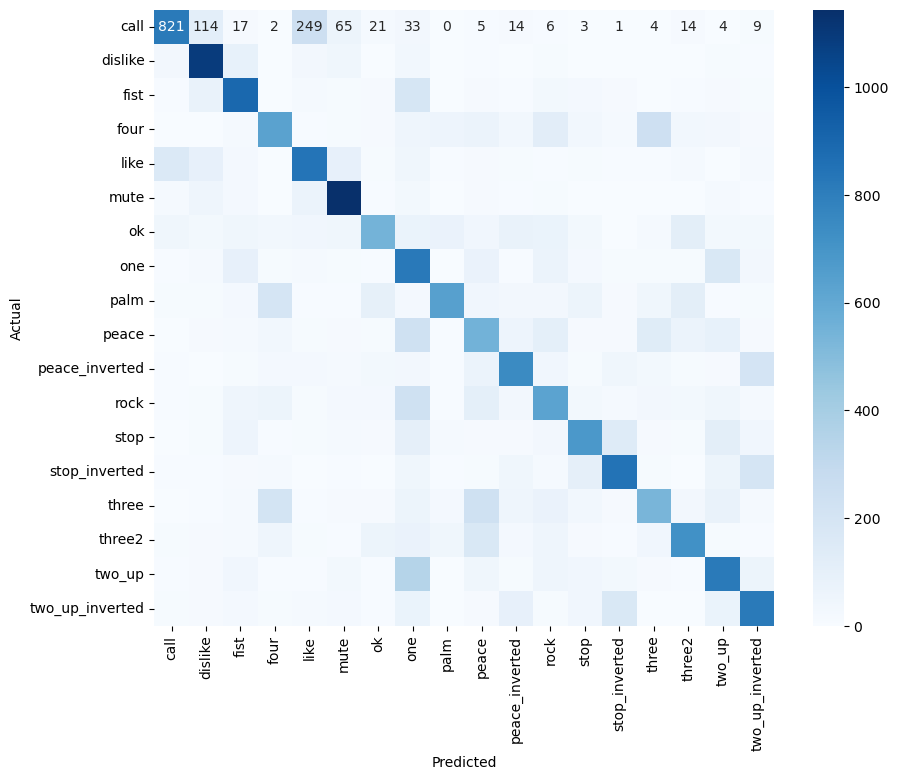


Evaluating VGG-16 Model:
1/1 [==============================] - 0s 31ms/step
                 precision    recall  f1-score   support

           call       0.49      0.84      0.62      1380
        dislike       0.69      0.91      0.78      1386
           fist       0.49      0.74      0.59      1349
           four       0.36      0.58      0.45      1416
           like       0.50      0.09      0.15      1384
           mute       0.90      0.83      0.86      1423
             ok       0.39      0.27      0.32      1371
            one       0.34      0.67      0.45      1421
           palm       0.56      0.56      0.56      1399
          peace       0.29      0.13      0.18      1425
 peace_inverted       0.56      0.32      0.41      1326
           rock       0.41      0.40      0.41      1372
           stop       0.23      0.10      0.14      1338
  stop_inverted       0.35      0.78      0.49      1419
          three       0.44      0.24      0.31      1453
         

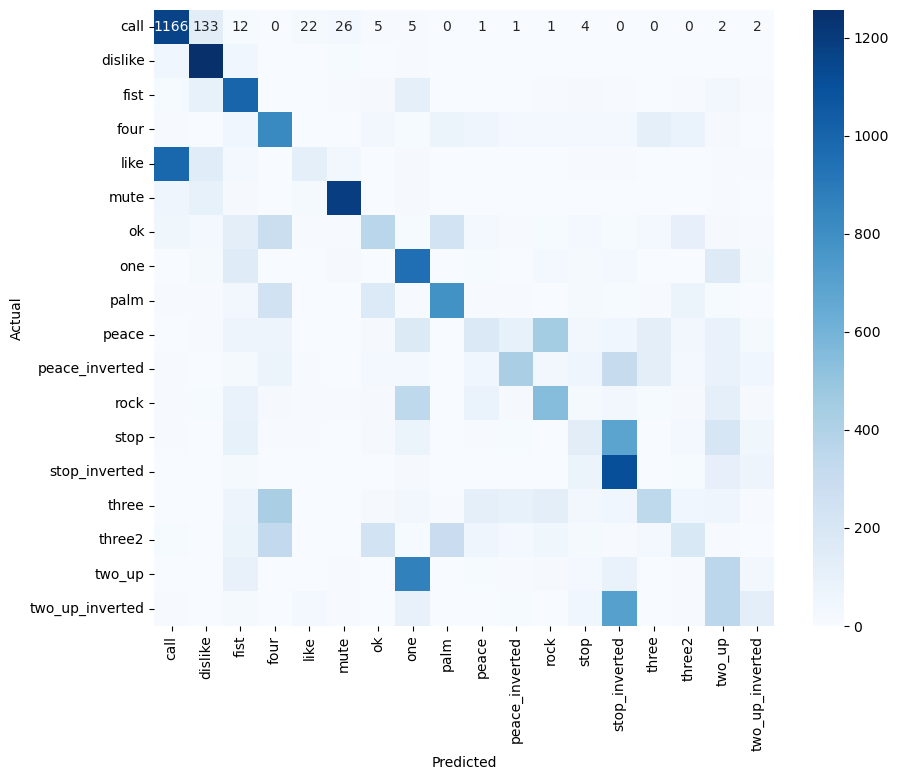

In [18]:
print("\nEvaluating Simple CNN:")
evaluate_model(simple_cnn, test_ds, class_names)

# Evaluate VGG-16
print("\nEvaluating VGG-16 Model:")
evaluate_model(vgg16_model, test_ds, class_names)

# Custom Images

In [3]:
import PIL
from PIL import Image
# Load Custom Images and Test the Final Model
def load_custom_images_pillow(image_paths, img_size=(256, 256)):
    images = []
    for img_path in image_paths:
        img = Image.open(img_path).resize(img_size)
        img_array = np.array(img) / 255.0
        if img_array.shape[-1] == 3:  # Ensure it's an RGB image
            images.append(img_array)
        else:  # If it's grayscale, convert to RGB
            images.append(np.stack([img_array] * 3, axis=-1))
    return np.array(images)

# Replace with paths to your four custom images
custom_images = [
    'images/images1.jpg',
    'images/images2.jpg',
    'images/image3.jpg',
    'images/image4.jpg'
]

# Example Usage with Final Model (replace vgg16_model with your best model)
custom_images_data = load_custom_images_pillow(custom_images)
predictions = simple_cnn.predict(custom_images_data)

# Print predictions
for i, pred in enumerate(predictions):
    predicted_label = class_names[tf.argmax(pred).numpy()]
    print(f"Custom Image {i+1}: Predicted Label = {predicted_label}")

NameError: name 'np' is not defined

# 1pm 07/05 - Different attempt

# Load

In [3]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
import time
from tensorflow.keras import mixed_precision

# Enable Mixed Precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Load Dataset
student_id_seed = 383711  

dataset_dir = 'E:\\GUI\\hagridset'  
image_size = (64, 64)
batch_size = 16
validation_split = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=student_id_seed,
    image_size=image_size,
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=student_id_seed,
    image_size=image_size,
    batch_size=batch_size
)

# Save the class names
class_names = train_ds.class_names
num_classes = len(class_names)

# Further split validation set into val and test
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2 * val_batches) // 3)
val_ds = val_ds.skip((2 * val_batches) // 3)

# Cache and prefetch data for performance improvement
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 125912 files belonging to 18 classes.
Using 100730 files for training.
Found 125912 files belonging to 18 classes.
Using 25182 files for validation.


# Define and train cnn 

Epoch 1/10
6296/6296 [==============================] - 245s 33ms/step - loss: 2.1529 - accuracy: 0.3049 - val_loss: 1.4390 - val_accuracy: 0.5410
Epoch 2/10
6296/6296 [==============================] - 54s 9ms/step - loss: 1.4322 - accuracy: 0.5336 - val_loss: 1.1212 - val_accuracy: 0.6390
Epoch 3/10
6296/6296 [==============================] - 54s 9ms/step - loss: 1.1783 - accuracy: 0.6159 - val_loss: 0.9199 - val_accuracy: 0.7027
Epoch 4/10
6296/6296 [==============================] - 54s 9ms/step - loss: 1.0528 - accuracy: 0.6571 - val_loss: 0.8931 - val_accuracy: 0.7204
Epoch 5/10
6296/6296 [==============================] - 54s 9ms/step - loss: 0.9667 - accuracy: 0.6839 - val_loss: 0.8091 - val_accuracy: 0.7401
Epoch 6/10
6296/6296 [==============================] - 54s 9ms/step - loss: 0.9121 - accuracy: 0.7030 - val_loss: 0.7558 - val_accuracy: 0.7530
Epoch 7/10
6296/6296 [==============================] - 55s 9ms/step - loss: 0.8628 - accuracy: 0.7176 - val_loss: 0.7577 - val_

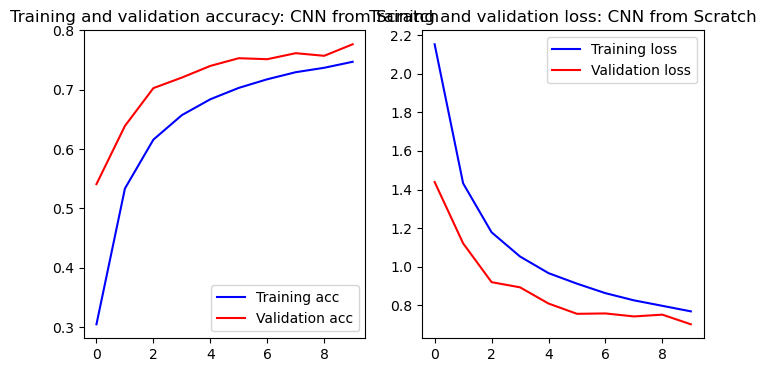

In [4]:
# Function to build a simple CNN model
def build_scratch_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train and evaluate the scratch model
input_shape = (64, 64, 3)

model_scratch = build_scratch_model(input_shape, num_classes)
history_scratch = model_scratch.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size
)

# Evaluate on test set
test_loss, test_acc = model_scratch.evaluate(test_ds)
print(f"Scratch Model Test Accuracy: {test_acc:.2f}")

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

# Plot history
plot_history(history_scratch, "CNN from Scratch")

# Transfer learning

Epoch 1/10
6296/6296 [==============================] - 74s 11ms/step - loss: 2.9657 - accuracy: 0.1207 - val_loss: 2.4653 - val_accuracy: 0.1889
Epoch 2/10
6296/6296 [==============================] - 71s 11ms/step - loss: 2.5881 - accuracy: 0.1671 - val_loss: 2.3536 - val_accuracy: 0.2401
Epoch 3/10
6296/6296 [==============================] - 70s 11ms/step - loss: 2.5321 - accuracy: 0.1853 - val_loss: 2.3410 - val_accuracy: 0.2423
Epoch 4/10
6296/6296 [==============================] - 71s 11ms/step - loss: 2.5038 - accuracy: 0.1931 - val_loss: 2.3438 - val_accuracy: 0.2452
Epoch 5/10
6296/6296 [==============================] - 74s 12ms/step - loss: 2.4941 - accuracy: 0.1936 - val_loss: 2.2803 - val_accuracy: 0.2623
Epoch 6/10
6296/6296 [==============================] - 75s 12ms/step - loss: 2.4820 - accuracy: 0.1991 - val_loss: 2.3100 - val_accuracy: 0.2498
Epoch 7/10
6296/6296 [==============================] - 70s 11ms/step - loss: 2.4749 - accuracy: 0.2002 - val_loss: 2.2761 -

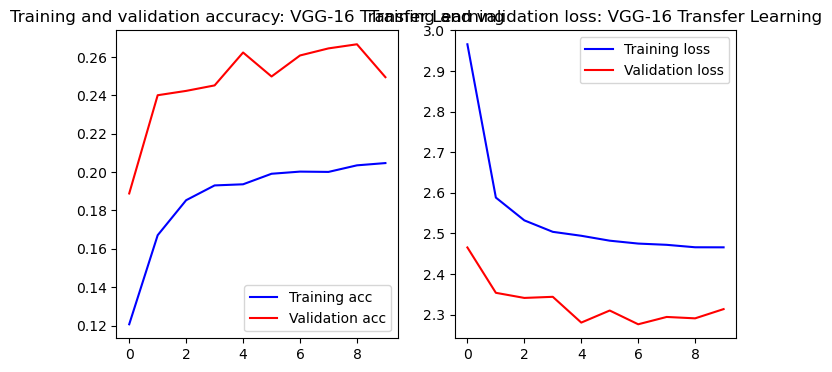

In [6]:
# Load VGG-16 Model with Transfer Learning
def build_transfer_model(input_shape, num_classes):
    base_model = VGG16(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False
    )
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train and evaluate the transfer model
input_shape = (64, 64, 3)
model_transfer = build_transfer_model(input_shape, num_classes)

history_transfer = model_transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size
)

# Evaluate on test set
test_loss, test_acc = model_transfer.evaluate(test_ds)
print(f"Transfer Learning Model Test Accuracy: {test_acc:.2f}")

# Plot history
plot_history(history_transfer, "VGG-16 Transfer Learning")

# Comparison and Testing

In [17]:
# Compare inference times
import time

def measure_inference_time(model, dataset):
    start_time = time.time()
    model.evaluate(dataset)
    elapsed_time = time.time() - start_time
    return elapsed_time

inference_time_scratch = measure_inference_time(model_scratch, test_ds)
inference_time_transfer = measure_inference_time(model_transfer, test_ds)

print(f"Inference Time - Scratch Model: {inference_time_scratch:.2f}s")
print(f"Inference Time - Transfer Model: {inference_time_transfer:.2f}s")


1049/1049 [==============================] - 10s 10ms/step - loss: 2.2987 - accuracy: 0.2527
Inference Time - Scratch Model: 4.87s
Inference Time - Transfer Model: 10.18s


In [19]:
# Final test using self-taken images
from tensorflow.keras.preprocessing import image

def predict_gesture(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    return predicted_class

# Assuming you have your images in '/content/my_gestures'
gesture_images = ['images/1.jpg',
                  'images/2.jpg',
                  'images/3.jpg',
                  'images/4.jpg']

for img_path in gesture_images:
    predicted_gesture = predict_gesture(model_scratch, img_path, class_names)
    print(f"Prediction for {img_path}: {predicted_gesture}")


1/1 [==============================] - 0s 28ms/step
Prediction for images/1.jpg: fist
1/1 [==============================] - 0s 20ms/step
Prediction for images/2.jpg: rock
1/1 [==============================] - 0s 20ms/step
Prediction for images/3.jpg: one
1/1 [==============================] - 0s 22ms/step
Prediction for images/4.jpg: palm
